# Progetto Corò Elia

In [1]:
# import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.semi_supervised import LabelPropagation
from utils.print_correlation_matrix import PrintCorrelationMatrix

from cleaning.fill_missing_values import fill_missing_values
from cleaning.remove_high_missing_fields import remove_high_missing_fields
from cleaning.remove_high_missing_columns import remove_high_missing_columns
from cleaning.one_hot_encoder import OneHotEncoderFunction
models = []
ids = []

## Data Initial Cleaning

In [2]:
def pre_processing(data):
    # Mantieni solo le colonne presenti nel set di test
    # Questa operazione potrebbe rimuovere colonne se 'train.csv' ha colonne extra
    test_columns = list(pd.read_csv('test.csv').columns) + ['sii']
    data = data[test_columns]
    
    # Rimuovi la colonna 'id'
    #data = data.drop(columns=['id'])
    
    # Rimuovi tutte le colonne season
    season_col = [col for col in data.columns if 'Season' in col]
    data = data.drop(columns=season_col)
    print(f"Colonne season rimosse: {len(season_col)}")
    
    # Rimuovi colonne con più dell'80% di valori mancanti
    data, removed_columns = remove_high_missing_columns(data, threshold=0.80)
    print(f"Colonne rimosse: {len(removed_columns)}")
    
    # Separa le righe con 'sii' mancante senza rimuoverle
    data_with_sii = data[data['sii'].notna()]
    data_without_sii = data[data['sii'].isna()]
    
    # Rimuovi righe con più dell'80% di valori mancanti nel sottoinsieme con 'sii' valido
    clean_data, removed_rows = remove_high_missing_fields(data_with_sii, threshold=0.8)
    print(f"Righe rimosse con l'80% dei dati mancanti: {len(removed_rows)}")
    
    # Ricombina i dati
    data = pd.concat([clean_data, data_without_sii], ignore_index=True)
    
    # Controlla i valori mancanti in 'sii'
    missing_sii_count = data['sii'].isnull().sum()
    print(f"Numero di righe con 'sii' null: {missing_sii_count}")
    return data
    
# Carica i dati
data = pd.read_csv('train.csv')

data = pre_processing(data)
data


Colonne season rimosse: 10
Colonne rimosse: 4
Righe rimosse con l'80% dei dati mancanti: 179
Numero di righe con 'sii' null: 1224


,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,5,0,51.0,16.877316,46.0,50.8,NaN,NaN,NaN,...,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,3.0,2.0
1,000fd460,9,0,NaN,14.035590,48.0,46.0,22.0,75.0,70.0,...,21.0352,14.97400,39.4497,15.4107,27.0552,2.340,46.0,64.0,0.0,0.0
2,00105258,10,1,71.0,16.648696,56.5,75.6,NaN,65.0,94.0,...,NaN,NaN,NaN,NaN,NaN,2.170,38.0,54.0,2.0,0.0
3,00115b9f,9,0,71.0,18.292347,56.0,81.6,NaN,60.0,97.0,...,30.4041,16.77900,58.9338,26.4798,45.9966,2.451,31.0,45.0,0.0,1.0
4,001f3379,13,1,50.0,22.279952,59.5,112.2,NaN,60.0,73.0,...,32.9141,20.90200,79.6982,35.3804,63.1265,4.110,40.0,56.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3776,fe7c87e2,13,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.880,NaN,NaN,NaN,NaN
3777,fe7f68a7,15,1,NaN,22.457960,62.0,122.8,30.0,64.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,49.0,68.0,2.0,NaN
3778,ff0ab367,9,0,NaN,20.200490,52.5,79.2,28.0,75.0,92.0,...,NaN,NaN,NaN,NaN,NaN,1.990,NaN,NaN,0.0,NaN
3779,ffa9794a,10,0,NaN,18.764678,53.5,76.4,27.0,60.0,78.0,...,NaN,NaN,NaN,NaN,NaN,2.340,NaN,NaN,0.0,NaN


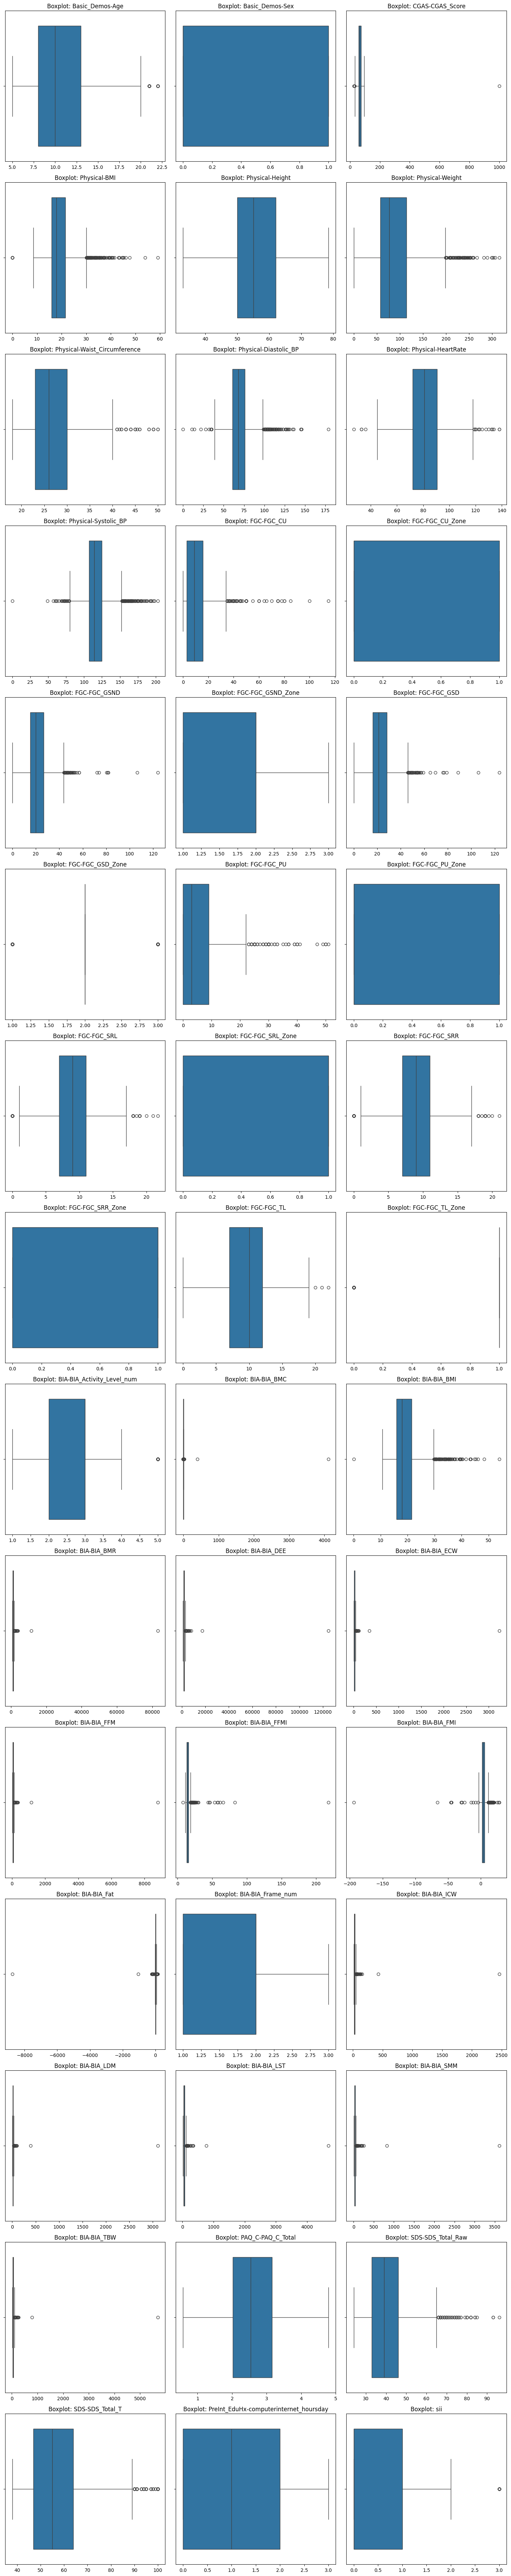

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_features_with_outliers(data):
    # Seleziona solo colonne numeriche
    numeric_data = data.select_dtypes(include=['number'])
    
    # Numero di feature
    num_features = len(numeric_data.columns)
    
    # Definisci il layout del grid plot
    n_cols = 3  # Numero di colonne per riga
    n_rows = (num_features // n_cols) + (num_features % n_cols > 0)
    
    # Crea i subplot
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    # Itera su ogni colonna numerica
    for i, column in enumerate(numeric_data.columns):
        sns.boxplot(data=numeric_data, x=column, ax=axes[i], whis=1.5)
        axes[i].set_title(f"Boxplot: {column}")
        axes[i].set_xlabel("")
        
    # Rimuovi eventuali subplot vuoti
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Usa la funzione con il dataset "data"
plot_features_with_outliers(data)


In [4]:
import numpy as np
from collections import Counter

def instances_cleaning(data):
    # Lista per raccogliere gli indici da rimuovere
    rows_to_remove = []
    
    # Non possono esserci valori troppo alti per CGAS-CGAS_Score
    rows_to_remove += data[data['CGAS-CGAS_Score'] > 800].index.tolist()
    
    # Il BMI non può essere <= 0
    rows_to_remove += data[data['Physical-BMI'] <= 0].index.tolist()

    # La pressione diastolica non può essere < 20 o > 150
    rows_to_remove += data[(data['Physical-Diastolic_BP'] < 20) | (data['Physical-Diastolic_BP'] > 150)].index.tolist()
    
    # La frequenza cardiaca non può essere inferiore a 40
    rows_to_remove += data[data['Physical-HeartRate'] < 40].index.tolist()
    
    # La pressione sistolica non può essere inferiore a 50
    rows_to_remove += data[data['Physical-Systolic_BP'] < 50].index.tolist()
    
    # Impostiamo a NaN i valori di grasso corporeo negativo, ma non rimuoviamo le righe
    data.loc[data['BIA-BIA_Fat'] < 0, 'BIA-BIA_Fat'] = np.nan
    
    # Impostiamo a NaN i valori di massa muscolare scheletrica troppo alti (più di 500)
    data.loc[data['BIA-BIA_SMM'] > 500, 'BIA-BIA_SMM'] = np.nan
    
    # Massa muscolare scheletrica troppo alta (> 500)
    rows_to_remove += data[data['BIA-BIA_SMM'] > 500].index.tolist()
    
    # L'acqua extracellulare non può essere troppo alta
    rows_to_remove += data[data['BIA-BIA_ECW'] > 400].index.tolist()
    
    # L'acqua intracellulare non può essere maggiore di 400
    rows_to_remove += data[data['BIA-BIA_ICW'] > 400].index.tolist()
    
    # La massa magra (Lean Soft Tissue) non può essere troppo alta
    rows_to_remove += data[data['BIA-BIA_LST'] > 4000].index.tolist()
    
    # Il totale di acqua corporea non può superare 1000
    rows_to_remove += data[data['BIA-BIA_TBW'] > 1000].index.tolist()
    
    index_counter = Counter(rows_to_remove)
    
    # Filtra gli indici che compaiono meno di 3 volte (quindi vengono rimossi)
    # Ci sono alcune occorrenze che eccedeno molte volte, teniamo dato che potrebbero essere dei casi "limite" più che errori
    rows_to_remove_filtered = [index for index, count in index_counter.items() if count < 3]

    print("Numero di righe rimosse: " + str(len(rows_to_remove_filtered)))
    return data.drop(rows_to_remove_filtered)

data = instances_cleaning(data)
data


Numero di righe rimosse: 18


,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,5,0,51.0,16.877316,46.0,50.8,NaN,NaN,NaN,...,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,3.0,2.0
1,000fd460,9,0,NaN,14.035590,48.0,46.0,22.0,75.0,70.0,...,21.0352,14.97400,39.4497,15.4107,27.0552,2.340,46.0,64.0,0.0,0.0
2,00105258,10,1,71.0,16.648696,56.5,75.6,NaN,65.0,94.0,...,NaN,NaN,NaN,NaN,NaN,2.170,38.0,54.0,2.0,0.0
3,00115b9f,9,0,71.0,18.292347,56.0,81.6,NaN,60.0,97.0,...,30.4041,16.77900,58.9338,26.4798,45.9966,2.451,31.0,45.0,0.0,1.0
4,001f3379,13,1,50.0,22.279952,59.5,112.2,NaN,60.0,73.0,...,32.9141,20.90200,79.6982,35.3804,63.1265,4.110,40.0,56.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3776,fe7c87e2,13,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.880,NaN,NaN,NaN,NaN
3777,fe7f68a7,15,1,NaN,22.457960,62.0,122.8,30.0,64.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,49.0,68.0,2.0,NaN
3778,ff0ab367,9,0,NaN,20.200490,52.5,79.2,28.0,75.0,92.0,...,NaN,NaN,NaN,NaN,NaN,1.990,NaN,NaN,0.0,NaN
3779,ffa9794a,10,0,NaN,18.764678,53.5,76.4,27.0,60.0,78.0,...,NaN,NaN,NaN,NaN,NaN,2.340,NaN,NaN,0.0,NaN


In [5]:
def standardize_dataframe(df):
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_columns = [col for col in numeric_columns if col != 'sii']

    # Mantieni i valori originali di 'sii'
    sii_original = df['sii'].copy()

    scaler = StandardScaler()
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

    # Ripristina i valori nulli di 'sii'
    df['sii'] = sii_original

    return df


data = standardize_dataframe(data)
data

,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,-1.524640,-0.768406,-1.178479,-0.495518,-1.330149,-0.895995,NaN,NaN,NaN,...,-0.152916,-0.156316,-0.259604,-0.703683,-0.162563,NaN,NaN,NaN,1.766356,2.0
1,000fd460,-0.402720,-0.768406,NaN,-1.059613,-1.062669,-1.005545,-0.948498,0.400491,-0.860283,...,-0.214039,-0.069246,-0.254661,-0.934869,-0.206426,-0.324595,0.458171,0.460771,-0.972182,0.0
2,00105258,-0.122240,1.301395,0.514075,-0.540900,0.074118,-0.329984,NaN,-0.351053,0.911930,...,NaN,NaN,NaN,NaN,NaN,-0.543092,-0.301760,-0.290412,0.853510,0.0
3,00115b9f,-0.402720,-0.768406,0.514075,-0.214628,0.007249,-0.193045,NaN,-0.726825,1.133456,...,-0.045596,-0.043392,-0.073623,-0.315342,-0.059005,-0.181930,-0.966700,-0.966477,-0.972182,1.0
4,001f3379,0.719201,1.301395,-1.263107,0.576929,0.475338,0.505339,NaN,-0.726825,-0.638756,...,-0.000469,0.015666,0.119310,0.182815,0.074317,1.950339,-0.111778,-0.140175,-0.972182,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3776,fe7c87e2,0.719201,-0.768406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.915821,NaN,NaN,NaN,NaN
3777,fe7f68a7,1.280161,1.301395,NaN,0.612265,0.809687,0.747263,0.487946,-0.426208,-1.598704,...,NaN,NaN,NaN,NaN,NaN,NaN,0.743145,0.761245,0.853510,NaN
3778,ff0ab367,-0.402720,-0.768406,NaN,0.164147,-0.460840,-0.247821,0.128835,0.400491,0.764245,...,NaN,NaN,NaN,NaN,NaN,-0.774441,NaN,NaN,-0.972182,NaN
3779,ffa9794a,-0.122240,-0.768406,NaN,-0.120868,-0.327101,-0.311725,-0.050720,-0.726825,-0.269545,...,NaN,NaN,NaN,NaN,NaN,-0.324595,NaN,NaN,-0.972182,NaN


In [6]:
data = OneHotEncoderFunction(data, ['id', 'sii'])
data

,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,...,Physical-HeartRate,Physical-Height,Physical-Systolic_BP,Physical-Waist_Circumference,Physical-Weight,PreInt_EduHx-computerinternet_hoursday,SDS-SDS_Total_Raw,SDS-SDS_Total_T,id,sii
0,-0.632337,-0.041820,-0.492199,-0.160478,-0.199835,-0.169644,-0.160478,-0.331113,-0.330634,-0.682296,...,NaN,-1.330149,NaN,NaN,-0.895995,1.766356,NaN,NaN,00008ff9,2.0
1,-0.632337,-0.042785,-1.055001,-0.158243,-0.197475,-0.200280,-0.158243,-0.635619,-0.765415,-0.942106,...,-0.860283,-1.062669,0.294669,-0.948498,-1.005545,-0.972182,0.458171,0.460771,000fd460,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.911930,0.074118,-0.002020,NaN,-0.329984,0.853510,-0.301760,-0.290412,00105258,0.0
3,0.339434,-0.029108,-0.211977,-0.053548,-0.046736,-0.069125,-0.053546,-0.252462,-0.058230,-0.206051,...,1.133456,0.007249,-0.002020,NaN,-0.193045,-0.972182,-0.966700,-0.966477,00115b9f,1.0
4,-0.632337,-0.023817,2.142954,0.053708,-0.020828,0.131184,0.053706,0.549600,2.122709,2.229413,...,-0.638756,0.475338,-0.892089,NaN,0.505339,-0.972182,-0.111778,-0.140175,001f3379,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fe7c87e2,NaN
3777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.598704,0.809687,-0.654738,0.487946,0.747263,0.853510,0.743145,0.761245,fe7f68a7,NaN
3778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.764245,-0.460840,1.481428,0.128835,-0.247821,-0.972182,NaN,NaN,ff0ab367,NaN
3779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.269545,-0.327101,0.057318,-0.050720,-0.311725,-0.972182,NaN,NaN,ffa9794a,NaN


In [7]:
y = data['sii']
X = data.drop('sii', axis=1)

X_train_with_encoder, X_test_with_encoder, y_train, y_test = train_test_split(X, y, test_size=0.2)

ids = X_train_with_encoder['id']

X_train_with_encoder = X_train_with_encoder.drop(columns=['id'])
X_test_with_encoder = X_test_with_encoder.drop(columns=['id'])

In [8]:
ids # Salviamoci tutti i dati che utilizziamo per il training, i rimanenti saranno per il test

1751    ac29ec80
363     21f58fba
1317    80b46ffb
2636    105a2475
3207    8632ea2b
          ...   
1496    92bcf0e7
3080    6c2d0774
3241    8d5c76a5
228     1455e657
3723    f41a21c4
Name: id, Length: 3010, dtype: object

In [9]:
X_train_filled_with_encoder = fill_missing_values(X_train_with_encoder)
X_test_filled_with_encoder = fill_missing_values(X_test_with_encoder)

/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [10]:
# Leggi i file CSV e assegna le variabili
X_train_with_encoder = X_train_filled_with_encoder
X_test_with_encoder = X_test_filled_with_encoder


In [11]:
def fill_y_column(X, y_column):
    # Sostituisci i valori NaN con -1 in y_train
    y_column_filled = y_column.copy()
    y_column_filled = y_column_filled.fillna(-1)

    # Crea e addestra il modello di Label Propagation
    lp = LabelPropagation(kernel='rbf', n_neighbors=5, max_iter=100)
    lp.fit(X, y_column_filled)
    
    # Predici i valori mancanti
    y_pred = lp.predict(X)
    
    # Sostituisci i valori predetti dove c'erano NaN
    y_column_imputed = y_column.copy()
    y_column_imputed[np.isnan(y_column)] = y_pred[np.isnan(y_column)]
    
    # Ora y_train_imputed contiene i valori originali e quelli riempiti tramite Label Propagation
    return y_column_imputed

y_train = fill_y_column(X_train_with_encoder, y_train)
y_test = fill_y_column(X_test_with_encoder, y_test)

/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:322: ConvergenceWarning: max_iter=100 was reached without convergence.
  warnings.warn(
/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


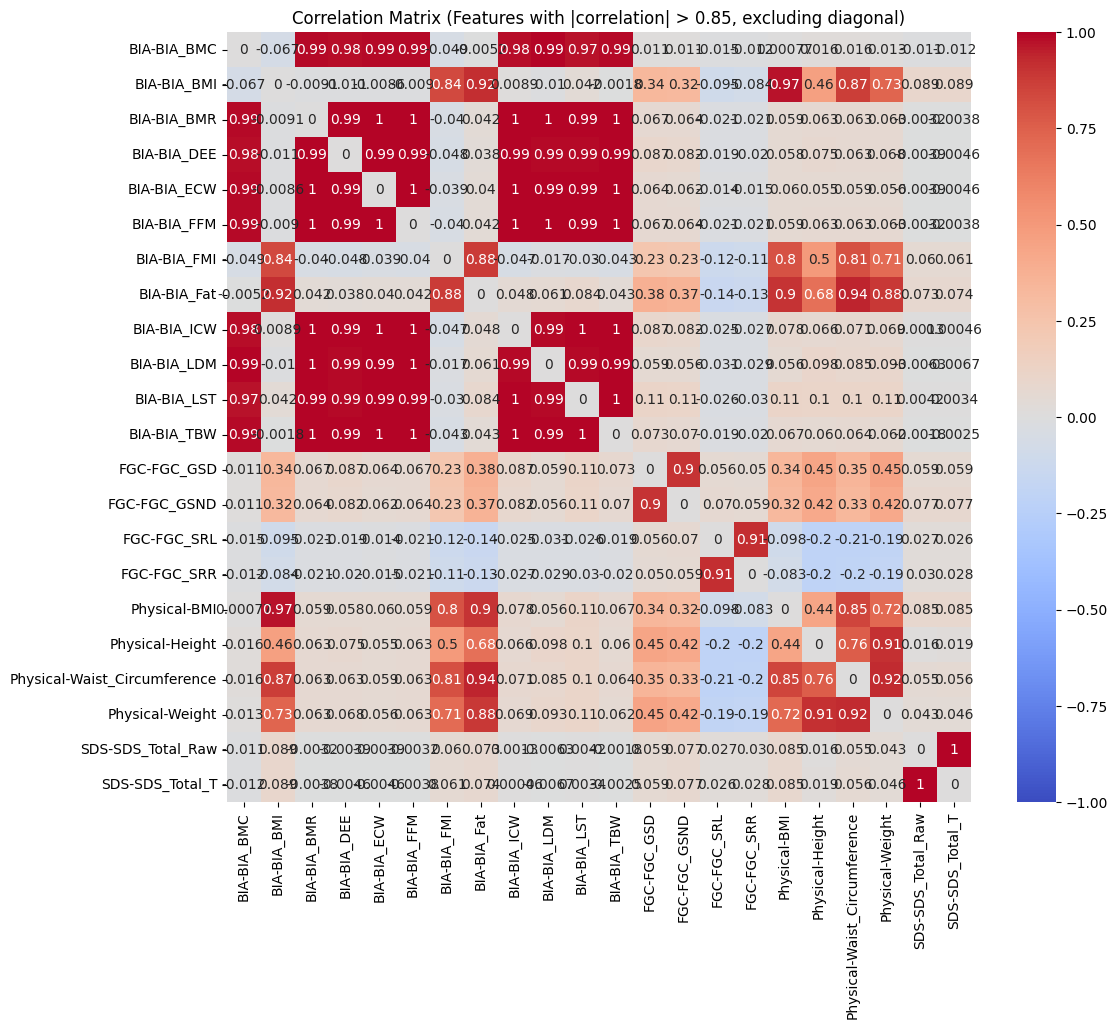

In [12]:
PrintCorrelationMatrix(X_train_with_encoder, 0.85)

Bia + Physical BMI provarle tutte e vedere la migliore
FGC-FGC_SRL, FGC-FGC_SRR prendere la media
togliere FGC-FGC_SRL_Zone
prendere SDS-SDS_Total_T ed escludere SDS-SDS_Total_Raw
Tutte le colonne PreInt_EduHx-Season le togliamo, sono colonne che indicano quando sono stati raccolti dati di interesse, ma di per sè sapere quando questi vengono raccolti non ce ne ciava un cazzo :)



In [13]:
def data_cleaning(df):
    # Per le seguenti colonne teniamo solo BIA-BIA_BMI
    to_remove = ['BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_ICW', 'BIA-BIA_FFM',
                 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW']
    # Elimina le colonne non necessarie
    df = df.drop(columns=[col for col in to_remove if col in df.columns])

    # Tra Physical-Waist_Circumference, Physical-Weight e Physical-BMI teniamo l'ultima
    to_remove = ['Physical-Waist_Circumference', 'Physical-Weight']
    df = df.drop(columns=[col for col in to_remove if col in df.columns])
    
    # Calcola la media tra 'FGC-FGC_SRL' e 'FGC-FGC_SRR'
    # FGC-FGC_SRL -> Forza di presa della mano dominante (misurata con un dinamometro)
    # FGC-FGC_SRR -> Forza di presa della mano non dominante (misurata con un dinamometro)
    if {'FGC-FGC_SRL', 'FGC-FGC_SRR'}.issubset(df.columns) and 'FGC-FGC_SRM' not in df.columns:
        df['FGC-FGC_SRM'] = (df['FGC-FGC_SRL'] + df['FGC-FGC_SRR']) / 2
        df = df.drop(columns=['FGC-FGC_SRL', 'FGC-FGC_SRR'])

    # Calcola la media tra 'FGC-FGC_GSD' e 'FGC-FGC_GSND'
    # FGC-FGC_GSD -> Forza di presa della mano dominante (misurata specificamente per la forza)
    # FGC-FGC_GSND -> Forza di presa della mano non dominante (misurata specificamente per la forza)
    if {'FGC-FGC_GSD', 'FGC-FGC_GSND'}.issubset(df.columns) and 'FGC-FGC_GSM' not in df.columns:
        df['FGC-FGC_GSM'] = (df['FGC-FGC_GSD'] + df['FGC-FGC_GSND']) / 2
        df = df.drop(columns=['FGC-FGC_GSD', 'FGC-FGC_GSND'])

    # Rimuovi tutte le colonne _Zone, sono delle categorizzazioni di altre colonne
    zone_col = [col for col in df.columns if '_Zone' in col]
    df = df.drop(columns=zone_col)
    print(f"Colonne _Zone rimosse: {zone_col}")

    # Mantieni solo 'SDS-SDS_Total_T' e rimuovi 'SDS-SDS_Total_Raw'
    # SDS-SDS_Total_T -> Punteggio T totale della scala di disturbi del sonno (punteggio standardizzato per la qualità del sonno)
    if 'SDS-SDS_Total_Raw' in df.columns:
        df = df.drop(columns=['SDS-SDS_Total_Raw'])

    # Tra BIA-BIA_BMI e Physical-BMI teniamo solo Physical-BMI
    # BIA-BIA_BMI -> valore calcolato sulla base del peso e dell'altezza
    # Physical-BMI -> misura ottenuta tramite macchinario
    to_remove = ['BIA-BIA_BMI']
    df = df.drop(columns=[col for col in to_remove if col in df.columns])

    # Rimuovi la colonna BIA-BIA_Fat
    # BIA-BIA_Fat -> Percentuale di grasso corporeo calcolata tramite analisi dell'impedenza bioelettrica (BIA).
    # BIA-BIA_FMI -> Indice di massa grassa calcolato dividendo la massa grassa per l'altezza al quadrato del partecipante
    # Rimuoviamo BIA-BIA_Fat e teniamo la versione normalizzata
    if 'BIA-BIA_Fat' in df.columns:
        df = df.drop(columns=['BIA-BIA_Fat'])

    return df

X_train_with_encoder = data_cleaning(X_train_with_encoder)
X_test_with_encoder = data_cleaning(X_test_with_encoder)


Colonne _Zone rimosse: ['FGC-FGC_CU_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone']
Colonne _Zone rimosse: ['FGC-FGC_CU_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone']


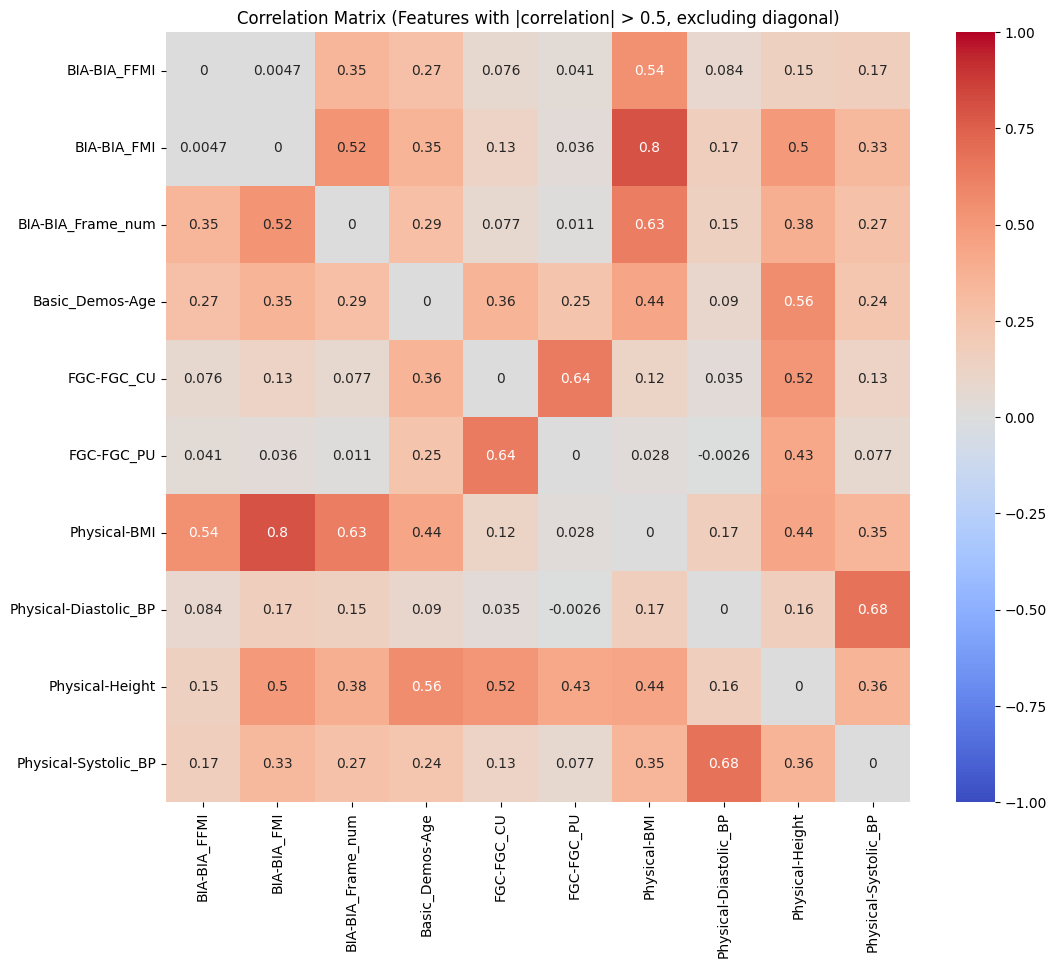

In [14]:
PrintCorrelationMatrix(X_train_with_encoder, 0.50)

In [15]:
X_train_with_encoder

,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Frame_num,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,FGC-FGC_CU,FGC-FGC_PU,...,PAQ_C-PAQ_C_Total,Physical-BMI,Physical-Diastolic_BP,Physical-HeartRate,Physical-Height,Physical-Systolic_BP,PreInt_EduHx-computerinternet_hoursday,SDS-SDS_Total_T,FGC-FGC_SRM,FGC-FGC_GSM
1751,2.282977,-0.048474,-0.008625,-1.159612,-1.096673,-0.963680,1.301395,1.106469,1.445641,2.106975,...,0.833050,-0.986931,0.851417,0.542719,-1.062669,-0.061358,-0.972182,-0.966477,-0.149229,-0.237702
363,0.213104,-0.046312,-0.395168,-0.608437,-0.435112,-0.402720,-0.768406,0.006309,-0.359534,1.139673,...,1.102058,-0.775670,1.678115,-1.155651,-0.795190,0.354007,-0.972182,-1.266950,-0.145559,-0.353021
1317,0.339434,-0.006555,-0.258723,-0.414536,0.373462,0.719201,-0.768406,-0.839968,1.675422,0.192664,...,0.022428,-0.519544,-0.351053,1.650351,1.545255,0.057318,0.853510,0.010061,-2.553259,0.002093
2636,-0.000686,-0.014165,-0.314791,-0.145282,-0.008773,1.280161,-0.768406,-0.416830,-0.029701,0.300893,...,-0.988323,-0.498117,-1.252906,0.838087,1.745865,-0.417386,0.579656,0.085180,0.463366,0.489345
3207,0.339434,-0.045351,-0.676739,-0.948527,-1.096673,-0.963680,-0.768406,-0.470145,-0.953062,-0.754345,...,0.737760,-1.240832,-0.426208,0.247350,-1.463888,-1.129441,-0.972182,0.085180,-0.218593,-0.608204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1496,0.222822,-0.046842,0.054825,-0.599471,-0.361606,-0.963680,-0.768406,1.275724,0.403575,-0.483771,...,0.546781,-0.620933,0.701108,-1.007967,-1.089417,-0.892089,-0.972182,-0.816240,0.729789,-0.150965
3080,0.047903,-0.032146,0.079672,-0.490505,-0.376307,-0.963680,-0.768406,-0.550541,-0.953062,-0.754345,...,-0.771858,-0.392990,0.701108,1.281140,-0.995799,0.354007,-0.972182,0.085180,0.365073,-0.360397
3241,0.164515,-0.047797,0.231668,-0.617650,-0.067579,-0.402720,1.301395,-0.454066,-0.680887,-0.728641,...,0.000515,-0.218376,-0.479567,-0.260684,-1.962269,-0.624475,-0.059336,0.085180,0.394638,-0.348345
228,-0.029839,-0.024645,0.548382,0.476711,0.505774,-1.524640,-0.768406,0.856817,-0.953062,-0.754345,...,-0.696361,0.923032,0.625954,2.536457,-1.463888,0.828711,-0.972182,0.085180,-0.656494,-0.212701


## Data preparation

In [16]:
from cleaning.rfecv_selection import rfecv_selection

column_number, selected_features = rfecv_selection(X_train_with_encoder, y_train)

# Mostra il numero delle feature selezionate
print(f"Numero di feature selezionate: {column_number}")

# Mostra le feature selezionate
print(f"Feature selezionate: {selected_features}")


Numero di feature selezionate: 19
Feature selezionate: ['BIA-BIA_BMC', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'FGC-FGC_CU', 'FGC-FGC_PU', 'FGC-FGC_TL', 'PAQ_C-PAQ_C_Total', 'Physical-BMI', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Height', 'Physical-Systolic_BP', 'PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_T', 'FGC-FGC_SRM', 'FGC-FGC_GSM']


In [17]:
from cleaning.rfe_selection import rfe_selection

column = rfe_selection(X_train_with_encoder, y_train, column_number)

data = pd.concat([X_train_with_encoder[column], y_train], axis=1)
column
# Sia RFECV che RFE hanno restituito le features nello stesso ordine

Index(['BIA-BIA_BMC', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'Basic_Demos-Age',
       'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'FGC-FGC_CU', 'FGC-FGC_PU',
       'FGC-FGC_TL', 'PAQ_C-PAQ_C_Total', 'Physical-BMI',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Height',
       'Physical-Systolic_BP', 'PreInt_EduHx-computerinternet_hoursday',
       'SDS-SDS_Total_T', 'FGC-FGC_SRM', 'FGC-FGC_GSM'],
      dtype='object')

In [19]:
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()

print("Distribuzione delle etichette nel training set:")
print(train_counts)

print("Distribuzione delle etichette nel test set:")
print(test_counts)


Distribuzione delle etichette nel training set:
sii
0.0    1693
1.0     874
2.0     411
3.0      32
Name: count, dtype: int64
Distribuzione delle etichette nel test set:
sii
0.0    474
1.0    193
2.0     77
3.0      9
Name: count, dtype: int64


In [20]:
# Il dataset è fortemente sbilanciato
# Come metrica per la valutazione dei modelli usiamo una media ponderata in base alla proporzione inversa 
# della quantità di classi, in modo che anche se una classe ha poche istanze tenterà di ottenere una media generale buona

# utilizziamo class_weight="balanced"

# Funzione per calcolare la inverse balanced accuracy
def inverse_balanced_accuracy(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)
    # Calcola la frequenza di ciascuna classe nel dataset
    class_counts = np.bincount(y_true)
    total_samples = len(y_true)
    
    # Calcola la frequenza inversa di ciascuna classe
    class_weights = total_samples / class_counts
    class_weights = class_weights / np.sum(class_weights)  # Normalizza i pesi per fare una somma di 1

    # Crea il parametro sample_weight in base alla classe di ogni campione
    sample_weights = class_weights[y_true]

    # Calcola la balanced accuracy utilizzando i pesi
    acc = balanced_accuracy_score(y_true, y_pred, sample_weight=sample_weights)
    
    return acc

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer

def grid_search_rf(X_train, y_train):
    model = RandomForestClassifier(
        n_jobs=-1,
        class_weight="balanced"
    )

    param_grid = {
        'max_depth': [10, 80, 100],
        'min_samples_leaf': [1, 3, 5]
    }

    # Usa la balanced_accuracy_score come metrica
    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=param_grid, 
        cv=10
    )

    # Esegui la ricerca
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")

    return best_params

# Esegui il grid search
parameters = grid_search_rf(X_train_with_encoder, y_train)


Best parameters: {'max_depth': 100, 'min_samples_leaf': 1}


Train Accuracy: 1.0000
Test Accuracy: 0.6494
Train Balanced Accuracy: 1.0000
Test Balanced Accuracy: 0.3182


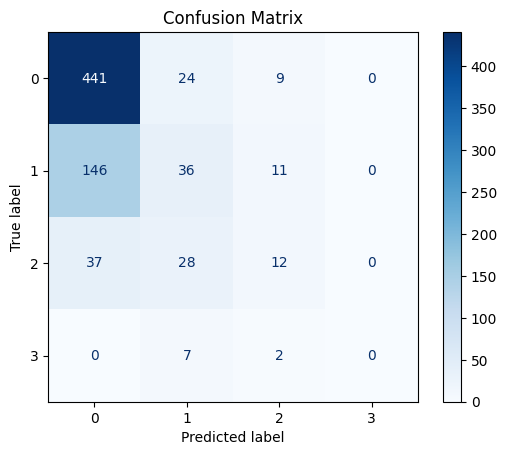

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from utils.print_confusion_matrix import print_confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.tree import plot_tree

model = RandomForestClassifier(**parameters)
#randomForestModel = model

model.fit(X_train_with_encoder, y_train)

y_train_pred = model.predict(X_train_with_encoder)
y_test_pred = model.predict(X_test_with_encoder[X_train_with_encoder.columns])

# Calcola l'accuracy per il training e il test
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Calcola la balanced accuracy per il training e il test
train_balanced_accuracy = inverse_balanced_accuracy(y_train, y_train_pred)
test_balanced_accuracy = inverse_balanced_accuracy(y_test, y_test_pred)

models.append({ 
    'model_name': 'Random Forest',
    'model': model,
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'train_balanced_accuracy': train_balanced_accuracy,
    'test_balanced_accuracy': test_balanced_accuracy
})

# Stampa i risultati
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Balanced Accuracy: {train_balanced_accuracy:.4f}")
print(f"Test Balanced Accuracy: {test_balanced_accuracy:.4f}")

print_confusion_matrix(y_test, y_test_pred)

In [23]:
# rimane una forte predominanza per la feature con classe 0
# Proviamo con un modello ANN
from tensorflow.keras.utils import to_categorical

y_train_categorial = to_categorical(y_train, num_classes=len(np.unique(y_train)))
y_test_categorial = to_categorical(y_test, num_classes=len(np.unique(y_train)))


2025-01-27 21:55:19.137283: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-27 21:55:19.137891: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-27 21:55:19.140391: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-27 21:55:19.144681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738011319.151409  351169 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738011319.15

In [24]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import balanced_accuracy_score
from itertools import product

# Funzione per creare il modello
def create_model(X_train, y_train, n_neurons=64, hidden_layer=1, dropout=True, activation='relu'):
    if hidden_layer < 1:
        raise ValueError("There should be at least one hidden layer")

    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))

    for _ in range(hidden_layer):
        model.add(Dense(n_neurons, activation=activation))
        if dropout:
            model.add(Dropout(0.25))

    model.add(Dense(len(np.unique(y_train)), activation='softmax'))

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [25]:
import itertools

# Definisci i pesi per ogni classe
weights_per_class = {
    0: [0.5, 0.8],
    1: [0.5, 0.8, 1],
    2: [1.5, 2],
    3: [1.5, 2]
}

# Crea una lista di tutte le combinazioni di pesi
weight_combinations = list(itertools.product(*weights_per_class.values()))

# Crea una funzione per ottenere i pesi per i campioni basata sulle combinazioni di pesi
def get_sample_weights(y, weight_combination, weights_per_class):
    sample_weights = np.zeros_like(y, dtype=float)
    for class_label, weight in zip(weights_per_class.keys(), weight_combination):
        class_indices = np.where(y == class_label)[0]
        sample_weights[class_indices] = weight
    return sample_weights

# Parametri da testare
n_neurons_options = [32, 64]
hidden_layer_options = [1, 3, 5, 10]
dropout_options = [True, False]

# Variabili per tracciare i migliori risultati
best_score = -np.inf
best_params = {}

# Make it faster ;)
n_neurons_options = [64]
hidden_layer_options = [5]
dropout_options = [True]
weight_combinations = [(0.5, 0.8, 1.5, 1.5)]

# Combinazione di tutte le possibili configurazioni di parametri
param_combinations = product(n_neurons_options, hidden_layer_options, dropout_options)

# Loop su ogni combinazione di parametri e pesi
for n_neurons, hidden_layer, dropout in param_combinations:
    for weight_combination in weight_combinations:
        print(f"Training with {n_neurons} neurons, {hidden_layer} hidden layers, dropout={dropout}")
        print(f"Using weight combination: {weight_combination}")

        # Ottieni i pesi per i campioni basati sulla combinazione corrente di pesi
        sample_weights = get_sample_weights(y_train, weight_combination, weights_per_class)

        # Crea il modello con i parametri correnti
        model = create_model(X_train_with_encoder, y_train, n_neurons=n_neurons, hidden_layer=hidden_layer, dropout=dropout)
        
        # Addestra il modello
        model.fit(
            X_train_with_encoder, 
            y_train_categorial, 
            epochs=10, 
            batch_size=128, 
            verbose=0, 
            sample_weight=sample_weights
        )

       # Previsioni e calcolo del punteggio per il training
        y_pred_train = model.predict(X_train_with_encoder)
        y_pred_train_numerical = np.argmax(y_pred_train, axis=1)  # Converti le previsioni one-hot in numeriche
        score_train = inverse_balanced_accuracy(np.argmax(y_train_categorial, axis=1), y_pred_train_numerical)
        
        # Previsioni e calcolo del punteggio per il test
        y_pred_test = model.predict(X_test_with_encoder)
        y_pred_test_numerical = np.argmax(y_pred_test, axis=1)  # Converti le previsioni one-hot in numeriche
        score_test = inverse_balanced_accuracy(np.argmax(y_test_categorial, axis=1), y_pred_test_numerical)



        print(f"Balanced Accuracy Train: {score_train}")
        print(f"Balanced Accuracy Test: {score_test}")

        # Se troviamo un punteggio migliore, aggiorniamo il migliore
        if score_test > best_score:
            best_score = score_test
            best_params = {
                'n_neurons': n_neurons,
                'hidden_layer': hidden_layer,
                'dropout': dropout,
                'weights': weight_combination
            }

# Stampa i migliori parametri e punteggio
print(f"Best parameters: {best_params}")
print(f"Best balanced accuracy score: {best_score}")


Training with 64 neurons, 5 hidden layers, dropout=True
Using weight combination: (0.5, 0.8, 1.5, 1.5)


W0000 00:00:1738011320.120721  351169 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
Balanced Accuracy Train: 0.44286266729942037
Balanced Accuracy Test: 0.33837353427272754
Best parameters: {'n_neurons': 64, 'hidden_layer': 5, 'dropout': True, 'weights': (0.5, 0.8, 1.5, 1.5)}
Best balanced accuracy score: 0.33837353427272754


In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

def plot_ann(history):
    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot training and validation accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
    if 'val_accuracy' in history.history:  # Correct key for validation accuracy
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.title('Accuracy During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


model = create_model(
    X_train_with_encoder, 
    y_train, 
    n_neurons=best_params['n_neurons'], 
    hidden_layer=best_params['hidden_layer'], 
    dropout=best_params['dropout'])

early_stopping = EarlyStopping(patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(
    verbose=1
)

# train the network
history = model.fit( x=X_train_with_encoder, # training examples
           y=y_train_categorial, # desired output
           epochs=45,
           verbose=1,
           validation_data=(X_test_with_encoder, y_test_categorial),
           class_weight={i: best_params['weights'][i] for i in range(len(best_params['weights']))},
           callbacks=[lr_scheduler, early_stopping]);
annModel = model

Epoch 1/45
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4764 - loss: 0.9076 - val_accuracy: 0.5710 - val_loss: 1.0173 - learning_rate: 0.0010
Epoch 2/45
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.4992 - loss: 0.8155 - val_accuracy: 0.4927 - val_loss: 1.0360 - learning_rate: 0.0010
Epoch 3/45
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - accuracy: 0.5308 - loss: 0.7985 - val_accuracy: 0.5046 - val_loss: 1.0149 - learning_rate: 0.0010
Epoch 4/45
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.5481 - loss: 0.7476 - val_accuracy: 0.4914 - val_loss: 1.0211 - learning_rate: 0.0010
Epoch 5/45
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.5939 - loss: 0.7398 - val_accuracy: 0.5179 - val_loss: 0.9976 - learning_rate: 0.0010
Epoch 6/45
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.5729 - loss: 0.7540 - val_accuracy: 0.5206 - val_loss: 1.0059 - learning_rate: 0.0010
Epoch 7/45
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.5873 - loss: 0.7235 - va

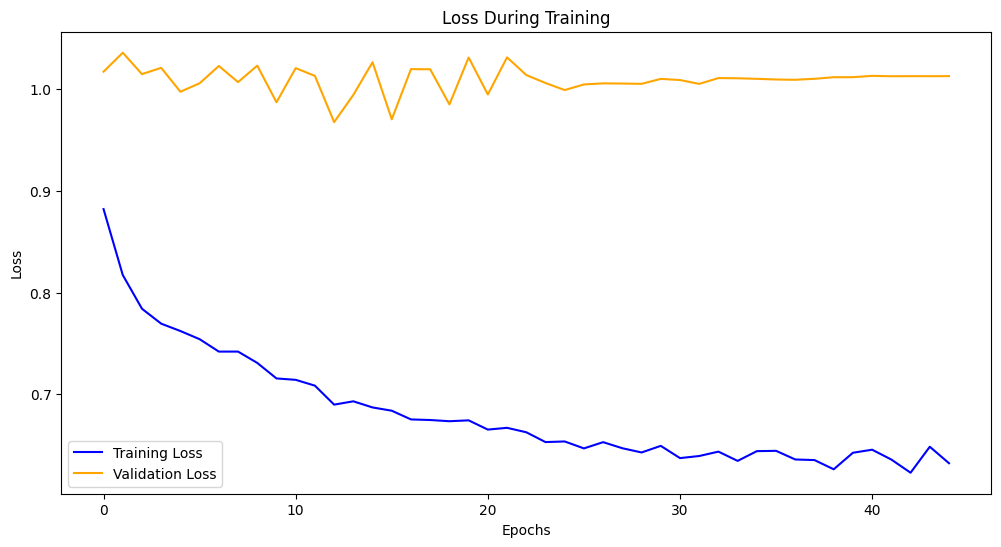

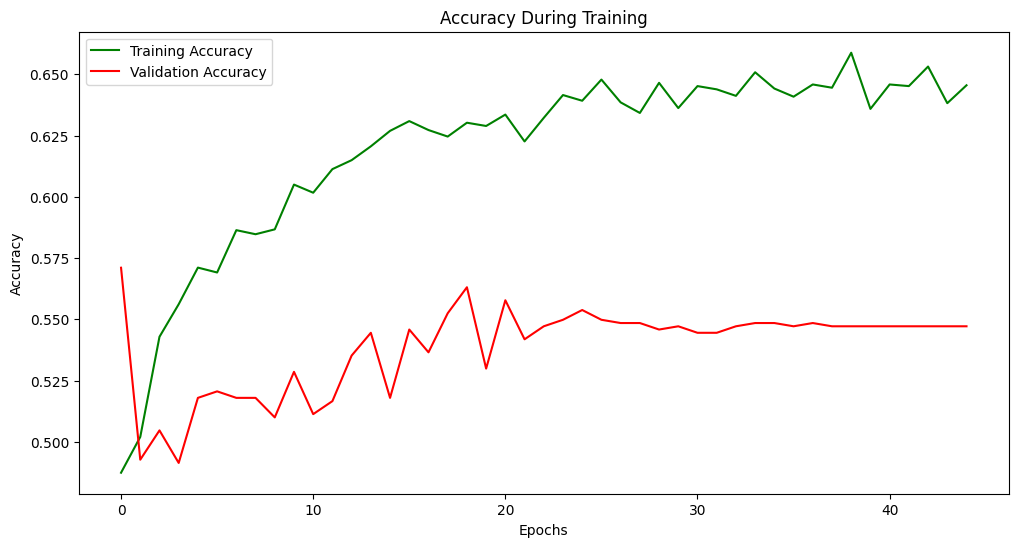

In [27]:
plot_ann(history)

Train Accuracy: 0.5439
Test Accuracy: 0.6255
Train Balanced Accuracy: 0.2482
Test Balanced Accuracy: 0.2680


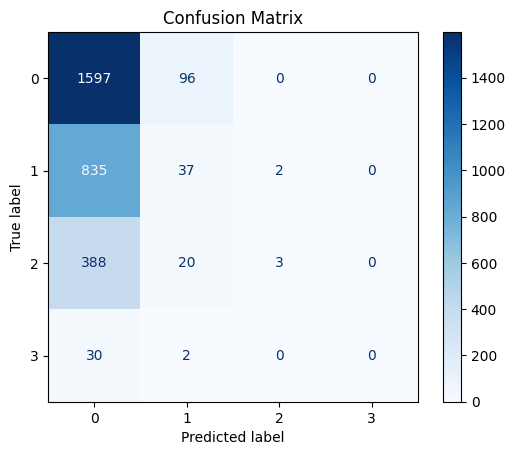

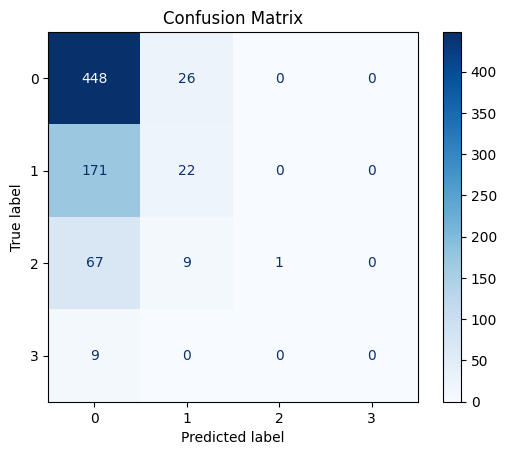

In [41]:
y_train_pred = model.predict(X_train_with_encoder)
y_test_pred = model.predict(X_test_with_encoder[X_train_with_encoder.columns])

# Converti le probabilità in etichette discrete (classi)
y_train_pred_label = np.argmax(y_train_pred, axis=1)
y_test_pred_label = np.argmax(y_test_pred, axis=1)

# Calcola l'accuracy per il training e il test
train_accuracy = accuracy_score(y_train, y_train_pred_label)
test_accuracy = accuracy_score(y_test, y_test_pred_label)

# Calcola la balanced accuracy per il training e il test
train_balanced_accuracy = inverse_balanced_accuracy(y_train, y_train_pred_label)
test_balanced_accuracy = inverse_balanced_accuracy(y_test, y_test_pred_label)

models.append({ 
    'model_name': 'ANN',
    'model': model,
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'train_balanced_accuracy': train_balanced_accuracy,
    'test_balanced_accuracy': test_balanced_accuracy
})

# Stampa i risultati
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Balanced Accuracy: {train_balanced_accuracy:.4f}")
print(f"Test Balanced Accuracy: {test_balanced_accuracy:.4f}")

# Stampa la matrice di confusione
print_confusion_matrix(y_train, y_train_pred_label)
print_confusion_matrix(y_test, y_test_pred_label)


In [29]:
# Meglio rispetto alla random forest

# lightgbm

In [42]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Carica i dati
data = pd.read_csv('train.csv')

data = pre_processing(data)
data = instances_cleaning(data)
data = standardize_dataframe(data)

train = data[data['id'].isin(ids)]
test = data[~data['id'].isin(ids)]

train_without_encoder = train.drop(columns=['id'])
test_without_encoder = test.drop(columns=['id'])

X_train_without_encoder = train_without_encoder.drop(columns=['sii'])
y_train_without_encoder = train_without_encoder['sii']

X_test_without_encoder = test_without_encoder.drop(columns=['sii'])
y_test_without_encoder = test_without_encoder['sii']

X_train_filled_without_encoder = fill_missing_values(X_train_without_encoder)
X_test_filled_without_encoder = fill_missing_values(X_test_without_encoder)

X_train_without_encoder = data_cleaning(X_train_without_encoder)
X_test_without_encoder = data_cleaning(X_test_without_encoder)

y_train_without_encoder = fill_y_column(X_train_filled_without_encoder, y_train_without_encoder)
y_test_without_encoder = fill_y_column(X_test_filled_without_encoder, y_test_without_encoder)

Colonne season rimosse: 10
Colonne rimosse: 4
Righe rimosse con l'80% dei dati mancanti: 179
Numero di righe con 'sii' null: 1224
Numero di righe rimosse: 18


KeyboardInterrupt: 

In [33]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Richiede troppo tempo allenare con la grid search, impostiamo dei parametri manualmente senza fare tuning

# Parametri base per LightGBM
#params = {
#    'objective': 'multiclass',
#    'metric': 'multi_logloss',
#    'num_class': len(y_train.unique()),
#    'boosting_type': 'gbdt',
#    'learning_rate': 0.05,
#    'feature_fraction': 0.9
#}

# Crea un dataset per LightGBM
#train_data = lgb.Dataset(X_train, label=y_train)
#test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Definizione dei parametri da ottimizzare
#param_grid = {
#    'num_leaves': [50],
#    'max_depth': [15],
#    'learning_rate': [0.1],
#    'n_estimators': [75],
#    'subsample': [0.7],
#    'colsample_bytree': [0.5]
#}

# Impostare il modello LightGBM per la ricerca dei migliori iperparametri
#model = lgb.LGBMClassifier(objective='multiclass', metric='multi_logloss', num_class=len(y_train.unique()))

# Esegui il grid search
#grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=100, scoring='accuracy', verbose=0, n_jobs=-1)

# Addestra il modello con il grid search
#grid_search.fit(X_train, y_train)

# I migliori parametri trovati
#print("Best parameters found: ", grid_search.best_params_)

In [34]:
# Creazione del dataset per LightGBM
train_data = lgb.Dataset(X_train_without_encoder, label=y_train)
test_data = lgb.Dataset(X_test_without_encoder, label=y_test, reference=train_data)

# Parametri del modello
params = {
    'objective': 'multiclass',          # Task di classificazione
    'num_class': len(y_train.unique()), # Numero di classi
    'boosting_type': 'gbdt',            # Tipo di boosting
    #'metric': 'multi_logloss',         # Metriche di valutazione
    'metric': 'multi_error',
    'learning_rate': 0.1,               # Tasso di apprendimento
    'num_leaves': 30,                   # Numero di foglie
    'max_depth': 15,                     # Profondità massima (non limitata)
    'verbose': 1,                      # Silenzia i log dettagliati
}

# Allenamento del modello
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=65,  #Valore trovato facendo un po' di prove
    
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2443
[LightGBM] [Info] Number of data points in the train set: 3010, number of used features: 21
[LightGBM] [Info] Start training from score -0.575438
[LightGBM] [Info] Start training from score -1.236615
[LightGBM] [Info] Start training from score -1.991102
[LightGBM] [Info] Start training from score -4.543959


Train Accuracy: 0.8777
Test Accuracy: 0.5803
Train Balanced Accuracy: 0.8428
Test Balanced Accuracy: 0.2470


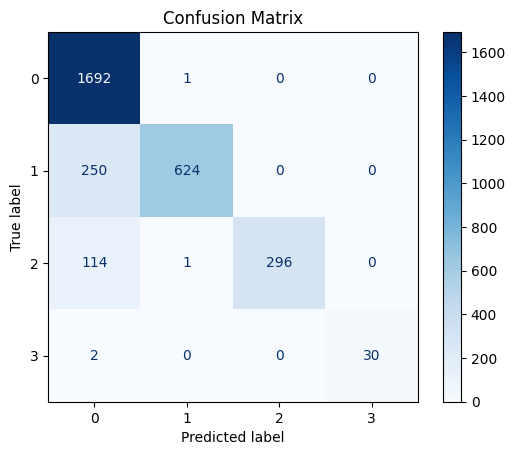

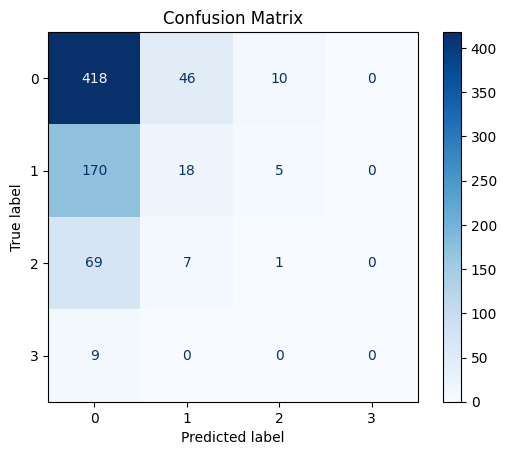

In [35]:
# Fare previsioni sul training e test set
y_train_pred = model.predict(X_train_without_encoder)
y_test_pred = model.predict(X_test_without_encoder)

# Convertire le probabilità in etichette
y_train_pred_label = y_train_pred.argmax(axis=1)
y_test_pred_label = y_test_pred.argmax(axis=1)

# Calcolare le metriche
train_accuracy = accuracy_score(y_train, y_train_pred_label)
test_accuracy = accuracy_score(y_test, y_test_pred_label)

train_balanced_accuracy = inverse_balanced_accuracy(y_train, y_train_pred_label)
test_balanced_accuracy = inverse_balanced_accuracy(y_test, y_test_pred_label)

models.append({ 
    'model_name': 'lightgbm',
    'model': model,
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'train_balanced_accuracy': train_balanced_accuracy,
    'test_balanced_accuracy': test_balanced_accuracy
})

# Stampare i risultati
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Balanced Accuracy: {train_balanced_accuracy:.4f}")
print(f"Test Balanced Accuracy: {test_balanced_accuracy:.4f}")

# Stampa la matrice di confusione
print_confusion_matrix(y_train, y_train_pred_label)
print_confusion_matrix(y_test, y_test_pred_label)


# Analisi dei risultati
Proviamo a predire tutto il dataset con tutti i modelli e vediamo su quali istanze commette errori e poi facciamo il plot.

In [43]:
import pandas as pd

X_with_encoder = X_train_with_encoder + X_test_with_encoder
X_without_encoder = X_train_without_encoder + X_test_without_encoder

y = y_train + y_test
models

['model_name',
 'model',
 'train_accuracy',
 'test_accuracy',
 'train_balanced_accuracy',
 'test_balanced_accuracy',
 'model_name',
 'model',
 'train_accuracy',
 'test_accuracy',
 'train_balanced_accuracy',
 'test_balanced_accuracy',
 'model_name',
 'model',
 'train_accuracy',
 'test_accuracy',
 'train_balanced_accuracy',
 'test_balanced_accuracy',
 'model_name',
 'model',
 'train_accuracy',
 'test_accuracy',
 'train_balanced_accuracy',
 'test_balanced_accuracy']

In [37]:
import pandas as pd

X_with_encoder = X_train_with_encoder + X_test_with_encoder
X_without_encoder = X_train_without_encoder + X_test_without_encoder

y = y_train + y_test

In [ ]:
lgbmModel_info = next(model for model in models if model['model_name'] == 'lightgbm')
randomForestModel_info = next(model for model in models if model['model_name'] == 'Random Forest')
annModel_info = next(model for model in models if model['model_name'] == 'ANN')


# Previsioni sui dati
y_pred_lgbm = [int(pred.argmax()) for pred in lgbmModel.predict(X_without_encoder)]
y_pred_rf = randomForestModel.predict(X_with_encoder[randomForestModel.feature_names_in_])
y_pred_ann = annModel.predict(X_with_encoder).argmax(axis=1)

# Trova istanze errate su tutti e tre i modelli
mistakes = (y != y_pred_lgbm) & (y != y_pred_rf) & (y != y_pred_ann)

# Trova istanze correttamente classificate da tutti e tre i modelli
correct_predictions = (y == y_pred_lgbm) & (y == y_pred_rf) & (y == y_pred_ann)

# Trova le istanze corrette e quelle errate
mistakes = (y != y_pred_lgbm) & (y != y_pred_rf) & (y != y_pred_ann)
correct_predictions = (y == y_pred_lgbm) & (y == y_pred_rf) & (y == y_pred_ann)

# Estrai le istanze corrette ed errate
correct_indices = correct_predictions[correct_predictions].index
incorrect_indices = mistakes[mistakes].index

correct_features = X.loc[correct_indices]
incorrect_features = X.loc[incorrect_indices]


# Output delle istanze errate
print(f"Numero di istanze errate su tutti e tre i modelli: {len(mistake_indices)}")
#print(mistake_instances)

# Output delle istanze corrette
print(f"Numero di istanze correttamente classificate da tutti e tre i modelli: {len(correct_indices)}")
#print(correct_instances)


In [ ]:
qwe qwe

In [39]:
qwe

NameError: name 'qwe' is not defined

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Visualizzare la distribuzione delle feature
num_features = len(X.columns)
n_cols = 3
num_rows = (num_features // n_cols) + (num_features % n_cols)  # Calcolare il numero di righe necessarie per avere 2 colonne per riga

plt.figure(figsize=(16, 6 * num_rows))  # Impostare l'altezza in base al numero di righe
for i, feature in enumerate(X.columns, 1):
    plt.subplot(num_rows, n_cols, i)  # 2 colonne per riga
    sns.kdeplot(correct_features[feature], label='Correctly Classified', color='green', fill=True)
    sns.kdeplot(incorrect_features[feature], label='Incorrectly Classified', color='red', fill=True)
    plt.title(f'Distribuzione di {feature}')
    plt.legend()

plt.tight_layout()
plt.show()



In [ ]:

# Step 2: Calcolare e visualizzare la media delle feature
# Calcolo delle medie per le istanze corrette ed errate
correct_means = correct_features.mean()
incorrect_means = incorrect_features.mean()

# Creare un DataFrame combinato con media delle feature per le istanze corrette e errate
df_means = pd.DataFrame({
    'Correctly Classified': correct_means,
    'Incorrectly Classified': incorrect_means
})

# Ordinare i dati per facilitare la visualizzazione
df_means = df_means.sort_values(by='Correctly Classified', ascending=False)

# Plot delle medie delle feature
plt.figure(figsize=(12, 8))
df_means.plot(kind='bar', width=0.8, figsize=(15, 6))

# Aggiungere etichette e titolo
plt.title('Media delle feature per istanze correttamente ed erroneamente classificate', fontsize=16)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Media', fontsize=14)
plt.xticks(rotation=90)

# Legenda
plt.legend(title='Classification', fontsize=12)
plt.tight_layout()

# Mostra il plot
plt.show()
